In [8]:
import numpy as np
import matplotlib.pyplot as plt
duration = [20,30,40,50,60,70,80]

In [9]:
pulse_set = []
tlist = []
#We do 1000 optimizations for each duration. This cell aims to find the best pulse for each duration
#by comparing their cost values.
for i in range(len(duration)):
    name1 = 'pi_result_'+str(duration[i])+'_paras.npy'
    name2 = 'pi_result_'+str(duration[i])+'_results.npy'
    paras = np.load(name1,allow_pickle=True)[0]
    results = np.load(name2,allow_pickle=True)[0]
    
    best_index = None
    error = 1
    for k in range(len(results)):
        if results[k].best_error < error:
            error = results[k].best_error
            best_index = k
    resolution=10
    pulse  = [results[best_index].best_controls[0], results[best_index].best_controls[1]]
    envolope_0=np.array([])
    envolope_1=np.array([])
    for value in pulse[1]:
        for j in range(resolution):
            envolope_1 = np.append(envolope_1,value)
    for value in pulse[0]:
        for j in range(resolution):
            envolope_0 = np.append(envolope_0,value)
    pulse_set.append( [envolope_0, envolope_1])
    tlist_fine = np.linspace(0,duration[i],len(pulse_set[i][0]))
    tlist.append(tlist_fine)

In [10]:
import qutip as qt
def close_simulation(i):
    N_q = 5
    a_q = destroy(N_q)
    n_q = a_q.dag() * a_q
    x_q = a_q + a_q.dag()
    pulse = pulse_set[i]
    t_g = duration[i]
    cross_list = np.array([-10,-7,-4,-1,1,4,7,10])*1e-3*2*np.pi
    infidelity = 0
    for j in range(len(cross_list)):
        cross = cross_list[j]
        anhar = 200 * 1e-3 * 2*np.pi   # need to modify in python file 
        kerr_q = anhar / 2
        k_q = -200e-3 * 2*np.pi  
        H0 = ( cross * n_q 
          + 1/2*k_q * a_q.dag()**2 * a_q**2 
         )
        Hcx=a_q+a_q.dag()
        Hcy=-a_q*1j+1j*a_q.dag()
        target_states=np.zeros((N_q, N_q), dtype=np.complex128)
        target_states[0,1]=1
        target_states[1,0]=1
    # target_states[0,0] = 1/np.sqrt(2)
    # target_states[0,1] = -1j*1/np.sqrt(2)
    # target_states[1,0] = -1j*1/np.sqrt(2)
    # target_states[1,1] = 1/np.sqrt(2)

        U_ideal = Qobj(target_states)

        options = qt.Options(rtol=1e-10, atol=1e-10)

    
        qt_cx = pulse_set[i][0]
        qt_cy = pulse_set[i][1]
        qt_H=[H0,[Hcx,qt_cx],[Hcy,qt_cy]]

        output = qt.propagator(qt_H, tlist[i], c_op_list=[], args={}, options=options)

        infidelity += 1-np.abs(np.trace(U_ideal*output[-1].dag()))**2 / (2)**2
    infidelity = infidelity/8
    return infidelity

import qutip as qt
def open_simulation(i):
    N_q = 5
    a_q = destroy(N_q)
    n_q = a_q.dag() * a_q
    x_q = a_q + a_q.dag()
    pulse = pulse_set[i]
    t_g = duration[i]
    cross_list = np.array([-10,-7,-4,-1,1,4,7,10])*1e-3*2*np.pi
    infidelity = 0
    for j in range(len(cross_list)):
        cross = cross_list[j]
        anhar = 200 * 1e-3 * 2*np.pi   # need to modify in python file 
        kerr_q = anhar / 2
        k_q = -200e-3 * 2*np.pi  
        H0 = ( cross * n_q 
          + 1/2*k_q * a_q.dag()**2 * a_q**2 
         )
        Hcx=a_q+a_q.dag()
        Hcy=-a_q*1j+1j*a_q.dag()
        target_states=np.zeros((N_q, N_q), dtype=np.complex128)
        target_states[0,1]=1
        target_states[1,0]=1
        target_sup = np.kron(target_states,target_states)
    # target_states[0,0] = 1/np.sqrt(2)
    # target_states[0,1] = -1j*1/np.sqrt(2)
    # target_states[1,0] = -1j*1/np.sqrt(2)
    # target_states[1,1] = 1/np.sqrt(2)

        U_ideal = Qobj(target_states)

        options = qt.Options(rtol=1e-10, atol=1e-10)

    
    # qoc part 
        qt_cx = pulse_set[i][0]
        qt_cy = pulse_set[i][1]
        qt_H=[H0,[Hcx,qt_cx],[Hcy,qt_cy]]
        T_1 = 50000
        T_phi = 50000
        output = qt.propagator(qt_H, tlist[i], c_op_list=[np.sqrt(1/T_1)*a_q,np.sqrt(2/T_phi)*n_q], args={}, options=options)
    
        infidelity +=1-1/4*np.abs(np.trace(np.transpose(output[-1].data.toarray()@target_sup)))
    infidelity = infidelity/8
    return infidelity

In [5]:
from qutip import *
close_result = parallel_map(close_simulation, range(len(duration)), progress_bar=True)


14.3%. Run time:   0.69s. Est. time left: 00:00:00:04
28.6%. Run time:   0.96s. Est. time left: 00:00:00:02
42.9%. Run time:   1.10s. Est. time left: 00:00:00:01
57.1%. Run time:   1.30s. Est. time left: 00:00:00:00
71.4%. Run time:   1.48s. Est. time left: 00:00:00:00
85.7%. Run time:   1.72s. Est. time left: 00:00:00:00
100.0%. Run time:   1.85s. Est. time left: 00:00:00:00
Total run time:   1.88s


In [6]:
open_result = parallel_map(open_simulation, range(len(duration)), progress_bar=True)

14.3%. Run time:  11.87s. Est. time left: 00:00:01:11
28.6%. Run time:  17.27s. Est. time left: 00:00:00:43
42.9%. Run time:  21.02s. Est. time left: 00:00:00:28
57.1%. Run time:  26.12s. Est. time left: 00:00:00:19
71.4%. Run time:  30.84s. Est. time left: 00:00:00:12
85.7%. Run time:  35.79s. Est. time left: 00:00:00:05
100.0%. Run time:  39.50s. Est. time left: 00:00:00:00
Total run time:  39.54s


# This is original version of Fig 4 (a)

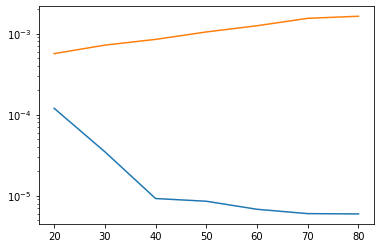

In [11]:
plt.plot(np.array(duration),close_result)
plt.plot(np.array(duration),open_result)
plt.yscale('log')

# This is original version of Fig 4 (b).
Note: index=0,1,..,6 corresponds to dutration 20,30,...,80

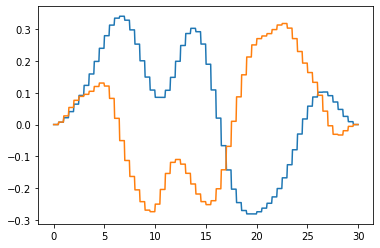

In [23]:
index = 1
plt.plot(tlist[index],pulse_set[index][0])
plt.plot(tlist[index],pulse_set[index][1])

(-500.0, 500.0)

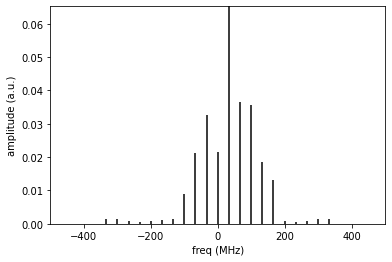

In [30]:
from numpy.fft import fft,fftfreq,ifft
def shift(freq,fourier):
    for i in range(len(freq)):
        if freq[i] < 0:
            freq = np.concatenate((freq[i:], freq[:i]))
            fourier = np.concatenate((fourier[i:], fourier[:i]))
            break
    return freq, fourier
overall_rt=pulse_set[index][0] - 1j* pulse_set[index][1]
fourier = np.abs(fft(overall_rt))
freq = fftfreq(len(tlist[index]), tlist[index][1]-tlist[index][0])
freq,fourier = shift(freq,fourier)
fig,ax=plt.subplots()
ax.stem(freq*1000, fourier/len(tlist_fine), 'k', markerfmt=' ', label='',basefmt=" ")
# ax.set_yscale('log')
ymax = max(fourier/len(tlist_fine))
ax.set(ylim=(0,ymax ), )
plt.xlabel('freq (MHz)')
plt.ylabel('amplitude (a.u.)')
plt.xlim([-500, 500])
# plt.savefig('qoc_pulse_ft.pdf', bbox_inches='tight')

In [28]:
import qutip as qt
import matplotlib.pyplot as plt
import numpy as np
from qutip import *
import scipy.special as sp
import scipy
from scipy.interpolate import interp1d

N_q = 5

a_q = destroy(N_q)
n_q = a_q.dag() * a_q
x_q = a_q + a_q.dag()

def dev_gaussian_env(t, sigma, chop, rot_angle, ti):  
    tg = chop * sigma
    tf = ti + tg
    amp = rot_angle / (np.sqrt(2*np.pi)*sigma*sp.erf(tg/(2*np.sqrt(2)*sigma)) - np.exp(-(tg/2)**2/(2*sigma**2))*tg)
    return (- amp * (t-ti-tg/2)/(sigma**2) * np.exp(-(t-ti-tg/2)**2/(2*sigma**2)) ) * np.heaviside(t - ti, 0) * np.heaviside(tf - t, 0)
def gaussian_env(t, sigma, chop, rot_angle, ti):  
    tg = chop * sigma
    tf = ti + tg
    amp = rot_angle / (np.sqrt(2*np.pi)*sigma*sp.erf(tg/(2*np.sqrt(2)*sigma)) - np.exp(-(tg/2)**2/(2*sigma**2))*tg)
    offset = amp * np.exp(-(tg/2)**2/(2*sigma**2))
    return (amp * np.exp(-(t-ti-tg/2)**2/(2*sigma**2)) - offset) * np.heaviside(t - ti, 0) * np.heaviside(tf - t, 0)

def func(i):

    cross = cross_list[i] * 1e-3 * 2*np.pi
    
    anhar = 200 * 1e-3 * 2*np.pi   # need to modify in python file 

    kerr_q = anhar / 2
    
    k_q = -200e-3 * 2*np.pi  

    H0 = ( cross * n_q 
          + 1/2*k_q * a_q.dag()**2 * a_q**2 
         )

    Hcx=a_q+a_q.dag()
    Hcy=-a_q*1j+1j*a_q.dag()

    target_states=np.zeros((N_q, N_q), dtype=np.complex128)
    target_states[0,1]=1
    target_states[1,0]=1
    # target_states[0,0] = 1/np.sqrt(2)
    # target_states[0,1] = -1j*1/np.sqrt(2)
    # target_states[1,0] = -1j*1/np.sqrt(2)
    # target_states[1,1] = 1/np.sqrt(2)
    target_sup = np.kron(target_states,target_states)
    U_ideal = Qobj(target_states)

    options = qt.Options(rtol=1e-10, atol=1e-10)

    
    # qoc part 
    qt_cx = pulse_set[index][0]
    qt_cy = pulse_set[index][1]
    qt_H=[H0,[Hcx,qt_cx],[Hcy,qt_cy]]
    T_1 = 50000
    T_phi = 50000
    output = qt.propagator(qt_H, tlist[index], c_op_list=[np.sqrt(1/T_1)*a_q,2*np.sqrt(1/T_phi)*n_q], args={}, options=options)
    robust = 1-1/4*np.abs(np.trace(np.transpose(output[-1].data.toarray()@target_sup)))
    output = qt.propagator(qt_H, tlist[index], c_op_list=[0*a_q], args={}, options=options)
    robust1 = 1-1/4*np.abs(np.trace(np.transpose(output[-1].data.toarray()@target_sup)))
    

    
    # drag part 
    drag_scale=1/2
    chop=4
    sigma=20/chop
    rot_angle=np.pi
    # rot_angle=np.pi/2
    qt_cx = gaussian_env(tlist[0], sigma, chop, rot_angle, 0)
    qt_cy = -dev_gaussian_env(tlist[0], sigma, chop, rot_angle, 0)/ (2*k_q) 
    qt_H=[H0,[Hcx,qt_cx/2],[Hcy,qt_cy/2]]
    
    target_sup = np.kron(target_states,target_states)
    # target_states[0,0] = 1/np.sqrt(2)
    # target_states[0,1] = -1j*1/np.sqrt(2)
    # target_states[1,0] = -1j*1/np.sqrt(2)
    # target_states[1,1] = 1/np.sqrt(2)
    
    T_phi = 50000
    output = qt.propagator(qt_H, tlist[0], c_op_list=[np.sqrt(1/T_1)*a_q,np.sqrt(2/T_phi)*n_q], args={}, options=options)
    drag = 1-1/4*np.abs(np.trace(np.transpose(output[-1].data.toarray()@target_sup)))
    output = qt.propagator(qt_H, tlist[0], c_op_list=[0*a_q], args={}, options=options)
    drag1 = 1-1/4*np.abs(np.trace(np.transpose(output[-1].data.toarray()@target_sup)))
    

    
    return robust, drag, robust1, drag1

In [29]:
cross_list = np.linspace(-20,20,201)
RESULT = parallel_map(func, range(len(cross_list)), progress_bar=True)

10.4%. Run time:  13.10s. Est. time left: 00:00:01:52
20.4%. Run time:  13.17s. Est. time left: 00:00:00:51
30.3%. Run time:  13.24s. Est. time left: 00:00:00:30
40.3%. Run time:  25.38s. Est. time left: 00:00:00:37
50.2%. Run time:  25.61s. Est. time left: 00:00:00:25
60.2%. Run time:  25.74s. Est. time left: 00:00:00:17
70.1%. Run time:  37.61s. Est. time left: 00:00:00:16
80.1%. Run time:  37.89s. Est. time left: 00:00:00:09
90.0%. Run time:  38.03s. Est. time left: 00:00:00:04
100.0%. Run time:  44.01s. Est. time left: 00:00:00:00
Total run time:  44.21s


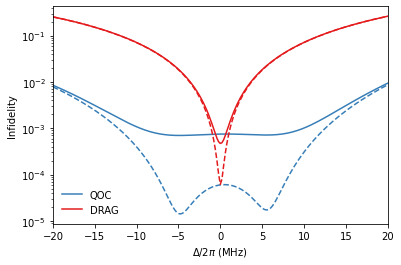

In [27]:
plt.plot(cross_list, np.array(RESULT)[:,0], '-', color = '#377eb8')
plt.plot(cross_list, np.array(RESULT)[:,1], '-', color = '#e41a1c')
plt.plot(cross_list, np.array(RESULT)[:,2], '--', color = '#377eb8')
plt.plot(cross_list, np.array(RESULT)[:,3], '--', color = '#e41a1c')
plt.yscale('log')
plt.legend(['QOC','DRAG'],frameon=False)
plt.xlim([-20,20])
plt.xlabel(r'$\Delta/2\pi$ (MHz)')
plt.ylabel('Infidelity')
plt.show()
# plt.savefig('qoc_pulse.pdf', bbox_inches='tight')